In [139]:
%pylab inline
import os
import re
import mrcfile
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from matplotlib.colors import LogNorm
import matplotlib.colors as clrs
from scipy.signal import savgol_filter

sys.path.append('/SIFT_gs/')
from SIFT_gs.FIBSEM_SIFT_gs import *

Populating the interactive namespace from numpy and matplotlib


In [140]:
def correlation_coefficient(frame1, frame2):
    product = np.mean((frame1 - frame1.mean()) * (frame2 - frame2.mean()))
    stds = frame1.std() * frame2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def read_transformation_matrix_from_xf_file(fn):
    npdt_recalled = pd.read_csv(fn, sep = '  ', header = None)
    tr = npdt_recalled.to_numpy()
    transformation_matrix = np.zeros((len(tr), 3, 3))
    transformation_matrix[:, 0, 0:2] = tr[:,0:2]
    transformation_matrix[:, 0, 2] = tr[:,6]
    transformation_matrix[:, 1, 0:2] = tr[:,2:4]
    transformation_matrix[:, 1, 2] = tr[:,9]
    transformation_matrix[:, 2, 2] = np.ones((len(tr)))   
    return transformation_matrix

def analyze_transformation_matrix(transformation_matrix, fn):
    Xshift_orig = transformation_matrix[:, 0, 2]
    Yshift_orig = transformation_matrix[:, 1, 2]
    Xscale_orig = transformation_matrix[:, 0, 0]
    Yscale_orig = transformation_matrix[:, 1, 1]
    tr_matr_cum = transformation_matrix.copy()

    prev_mt = np.eye(3,3)
    for j, cur_mt in enumerate(tqdm(transformation_matrix, desc='Calculating Cummilative Transformation Matrix')):
        prev_mt = np.matmul(cur_mt, prev_mt)
        tr_matr_cum[j] = prev_mt
    # Now insert identity matrix for the zero frame which does not need to be trasformed
    tr_matr_cum_orig = tr_matr_cum.copy()

    s00_cum_orig = tr_matr_cum[:, 0, 0].copy()
    s11_cum_orig = tr_matr_cum[:, 1, 1].copy()
    s01_cum_orig = tr_matr_cum[:, 0, 1].copy()
    s10_cum_orig = tr_matr_cum[:, 1, 0].copy()
    
    Xshift_cum_orig = tr_matr_cum_orig[:, 0, 2]
    Yshift_cum_orig = tr_matr_cum_orig[:, 1, 2]


    #print('Recalculating Shifts')
    s00_cum_orig = tr_matr_cum[:, 0, 0]
    s11_cum_orig = tr_matr_cum[:, 1, 1]
    fr = np.arange(0, len(s00_cum_orig))
    s00_slp = -1.0 * (np.sum(fr)-np.dot(s00_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s00_fit = 1.0 + s00_slp * fr
    s00_cum_new = s00_cum_orig + 1.0 - s00_fit
    s11_slp = -1.0 * (np.sum(fr)-np.dot(s11_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s11_fit = 1.0 + s11_slp * fr
    s11_cum_new = s11_cum_orig + 1.0 - s11_fit
    
    s01_slp = np.dot(s01_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s01_fit = s01_slp * fr
    s01_cum_new = s01_cum_orig - s01_fit
    s10_slp = np.dot(s10_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s10_fit = s10_slp * fr
    s10_cum_new = s10_cum_orig - s10_fit

    Xshift_cum = tr_matr_cum[:, 0, 2]
    Yshift_cum = tr_matr_cum[:, 1, 2]

    subtract_linear_fit=True

    # Subtract linear trend from offsets
    if subtract_linear_fit:
        fr = np.arange(0, len(Xshift_cum) )
        pX = np.polyfit(fr, Xshift_cum, 1)
        Xfit = np.polyval(pX, fr)
        pY = np.polyfit(fr, Yshift_cum, 1)
        Yfit = np.polyval(pY, fr)
        Xshift_residual = Xshift_cum - Xfit
        Yshift_residual = Yshift_cum - Yfit
    else:
        Xshift_residual = Xshift_cum.copy()
        Yshift_residual = Yshift_cum.copy()

    # define new cum. transformation matrix where the offests may have linear slopes subtracted
    tr_matr_cum_residual = tr_matr_cum.copy()
    tr_matr_cum_residual[:, 0, 2] = Xshift_residual
    tr_matr_cum_residual[:, 1, 2] = Yshift_residual
    tr_matr_cum_residual[:, 0, 0] = s00_cum_new
    tr_matr_cum_residual[:, 1, 1] = s11_cum_new
    tr_matr_cum_residual[:, 0, 1] = s01_cum_new
    tr_matr_cum_residual[:, 1, 0] = s10_cum_new

    fs = 12
    fig5, axs5 = subplots(3,3, figsize=(18, 12), sharex=True)
    fig5.subplots_adjust(left=0.15, bottom=0.08, right=0.99, top=0.94)

    # plot scales
    axs5[0, 0].plot(Xscale_orig, 'r', label = 'Sxx fr.-to-fr.')
    axs5[0, 0].plot(Yscale_orig, 'b', label = 'Syy fr.-to-fr.')
    axs5[0, 0].set_title('Frame-to-Frame Scale Change', fontsize = fs + 1)
    axs5[1, 0].plot(tr_matr_cum_orig[:, 0, 0], 'r', linestyle='dotted', label = 'Sxx cum.')
    axs5[1, 0].plot(tr_matr_cum_orig[:, 1, 1], 'b', linestyle='dotted', label = 'Syy cum.')
    axs5[1, 0].plot(s00_fit, 'r', label = 'Sxx cum. - lin. fit')
    axs5[1, 0].plot(s11_fit, 'b', label = 'Syy cum. - lin. fit')
    axs5[1, 0].set_title('Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].plot(tr_matr_cum_residual[:, 0, 0], 'r', label = 'Sxx cum. - residual')
    axs5[2, 0].plot(tr_matr_cum_residual[:, 1, 1], 'b', label = 'Syy cum. - residual')
    axs5[2, 0].set_title('Residual Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].set_xlabel('Frame', fontsize = fs + 1)
    
    # plot shears
    axs5[0, 1].plot(transformation_matrix[:, 0, 1], 'r', label = 'Sxy fr.-to-fr.')
    axs5[0, 1].plot(transformation_matrix[:, 1, 0], 'b', label = 'Syx fr.-to-fr.')
    axs5[0, 1].set_title('Frame-to-Frame Shear', fontsize = fs + 1)
    axs5[1, 1].plot(tr_matr_cum_orig[:, 0, 1], 'r', linestyle='dotted', label = 'Sxy cum.')
    axs5[1, 1].plot(tr_matr_cum_orig[:, 1, 0], 'b', linestyle='dotted', label = 'Syx cum.')
    axs5[1, 1].plot(s01_fit, 'r', label = 'Sxy cum. - lin. fit')
    axs5[1, 1].plot(s10_fit, 'b', label = 'Syx cum. - lin. fit')
    axs5[1, 1].set_title('Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].plot(tr_matr_cum_residual[:, 0, 1], 'r', label = 'Sxy cum. - residual')
    axs5[2, 1].plot(tr_matr_cum_residual[:, 1, 0], 'b', label = 'Syx cum. - residual')
    axs5[2, 1].set_title('Residual Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].set_xlabel('Frame', fontsize = fs + 1)

    # plot shifts
    axs5[0, 2].plot(Xshift_orig, 'r', label = 'Tx fr.-to-fr.')
    axs5[0, 2].plot(Yshift_orig, 'b', label = 'Ty fr.-to-fr.')
    axs5[0, 2].set_title('Frame-to-Frame Shift', fontsize = fs + 1)
    axs5[1, 2].plot(Xshift_cum, 'r', linestyle='dotted', label = 'Tx cum.')
    axs5[1, 2].plot(Xfit, 'r', label = 'Tx cum. - lin. fit')
    axs5[1, 2].plot(Yshift_cum, 'b', linestyle='dotted', label = 'Ty cum.')
    axs5[1, 2].plot(Yfit, 'b', label = 'Ty cum. - lin. fit')
    axs5[1, 2].set_title('Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].plot(tr_matr_cum_residual[:, 0, 2], 'r', label = 'Tx cum. - residual')
    axs5[2, 2].plot(tr_matr_cum_residual[:, 1, 2], 'b', label = 'Ty cum. - residual')
    axs5[2, 2].set_title('Residual Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].set_xlabel('Frame', fontsize = fs + 1)

    for ax in axs5.ravel():
        ax.grid(True)
        ax.legend()
    fig5.suptitle(fn, fontsize = fs + 2)
    fig5.savefig(fn +'_Transform_Summary.png', dpi=300)
    return fn

In [141]:
def plot_errs(errs, emin, emax, ax, col=None, lw=None, fs=12, fl=''):
    errs_stat = [np.mean(errs), np.median(errs), np.std(errs)]
    if col==None:
        col='g'
    if lw==None:
        lw=1
    ax.plot(errs, c=col, linewidth=lw)
    ax.set_ylabel('Mean Abs. Error of KeyPt Reg.')
    ax.set_ylim(emin, emax)
    #ax.text(0.015, 0.05, 'Err mean = {:.3}, Err median = {:.3f}, Err STD = {:.3f}'.format(errs_stat[0], errs_stat[1], errs_stat[2]), transform=ax.transAxes, fontsize = fs)
    #ax.text(0.015, 0.9, fl, transform=ax.transAxes, fontsize = fs+3)
    ax.grid(True)

def plot_imdif(image_diff, imin, imax, ax, col=None, lw=None, fs=12, fl=''):
    if col==None:
        col='r'
    if lw==None:
        lw=1
    imd = [np.mean(image_diff), np.median(image_diff), np.std(image_diff)] 
    ax.plot(image_diff, c=col, linewidth=lw)
    ax.set_ylabel('Image Δ')
    ax.set_ylim(imin, imax)
    #ax.text(0.015, 0.05, 'Δ mean = {:.1f},    Δ median = {:.1f},    Δ STD = {:.1f}'.format(imd[0], imd[1], imd[2]), transform=ax.transAxes, fontsize = fs)
    #ax.text(0.015, 0.9, fl, transform=ax.transAxes, fontsize = fs+3)
    ax.grid(True)

def plot_imncc(image_ncc, imin, imax, ax, col=None, lw=None, fs=12, fl=''):
    if col==None:
        col='b'
    if lw==None:
        lw=1
    imncc = [np.mean(image_ncc), np.median(image_ncc), np.std(image_ncc)] 
    ax.plot(image_ncc, c=col, linewidth=lw)
    ax.set_ylabel('Normalized Cross-Correlation')
    ax.set_ylim(imin, imax)
    #ax.text(0.015, 0.05, 'NCC mean = {:.3}, NCC median = {:.3f}, NCC STD = {:.3f}'.format(imncc[0], imncc[1], imncc[2]), transform=ax.transAxes, fontsize = fs)
    #ax.text(0.015, 0.9, fl, transform=ax.transAxes, fontsize = fs+3)
    ax.grid(True)    

def plot_imdif2(image_diff, imin, imax, ax, col=None, fs=12, fl=''):
    if col==None:
        col='r'
    imd = [np.mean(image_diff), np.median(image_diff), np.std(image_diff)] 
    ax.plot(image_diff, c=col, linewidth=1)
    #ax.set_ylabel('Image Δ')
    ax.set_ylim(imin, imax)
    ax.text(0.015, 0.17, 'Δ mean = {:.2f}'.format(imd[0]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.10, 'Δ median = {:.2f}'.format(imd[1]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.03, 'Δ STD = {:.2f}'.format(imd[2]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.9, fl, transform=ax.transAxes, fontsize = fs+3)
    ax.grid(True)

def plot_imncc2(image_ncc, imin, imax, ax, col=None, fs=12, fl=''):
    if col==None:
        col='b'
    imncc = [np.mean(image_ncc), np.median(image_ncc), np.std(image_ncc)] 
    ax.plot(image_ncc, c=col, linewidth=1)
    #ax.set_ylabel('Normalized Cross-Correlation')
    ax.set_ylim(imin, imax)
    ax.text(0.015, 0.17, 'NCC mean = {:.4f}'.format(imncc[0]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.10, 'NCC median = {:.4f}'.format(imncc[1]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.03, 'NCC STD = {:.4f}'.format(imncc[2]), transform=ax.transAxes, fontsize = fs)
    ax.text(0.015, 0.9, fl, transform=ax.transAxes, fontsize = fs+3)
    ax.grid(True)

def create_prefix1(flnm):
    prefix1 = 'Raw Data'
    if bool(re.search('_ShiftTransform_', flnm)):
        prefix1 = 'OpenCV Shift Transform'
    if bool(re.search('_ScaleShiftTransform_', flnm)):
        prefix1 = 'OpenCV Scale+Shift Transform'
    if bool(re.search('_AffineTransform_', flnm)):
        prefix1 = 'OpenCV Affine Transform'
    return prefix1

def create_prefix2(flnm):
    prefix2 = ''
    if bool(re.search('bi-lin', flnm)):
        prefix2 = 'bi-linear interp.'
    if bool(re.search('bi-cub', flnm)):
        prefix2 = 'bi-cubic interp.'
    return prefix2

In [266]:
def get_spread(data, window=501, porder=3):
    try:
        sm_data = savgol_filter(data.astype(double), window, porder)
        data_spread = np.std(data-sm_data)
    except:
        data_spread = 0.0
    return data_spread

In [296]:
data_dir = 'F:/FIB-SEM_SIFT/Shirish_WT1_RegData'
data_reg_qual_files = ['SIFTalignCombo-imgA_RegistrationQuality.csv',
                       'Registered_I16_AffineTransform_RANSAC_drmax1.0_const_scls_SG_shift_subtr_padded_bilin_RegistrationQuality.csv',
                       'Registered_I16_RegularizedAffineTransform_RANSAC_drmax1.0_const_scls_SG_shift_subtr_padded_l2_1e-05_RegistrationQuality.csv',
                       'Registered_I16_RegularizedAffineTransform_RANSAC_drmax1.0_const_scls_LF_shift_subtr_padded_bilin_v0_RegistrationQuality.csv',
                      'Registered_I16_ShiftTransform_RANSAC_drmax1.0_const_scls_SG_shift_subtr_padded_bilin_RegistrationQuality.csv']

reg_qual_fls = [os.path.join(data_dir, df) for df in data_reg_qual_files]
tran_mtrx_files = [df.replace('_RegistrationQuality.csv', '_Transform_Matrix_data.csv') for df in reg_qual_fls]
nfls = len(reg_qual_fls)

pfs = ['SIFTalignComboA',
       'Full Affine, SG',
      'Reg Aff, λ=1e-5, SG',
       'Reg Aff, λ=1e-5, LF',
      'Shift Only, SG']

reg_datas=[]
tran_mtrx_datas = []
tran_mtrx_res_datas = []

for j, df in enumerate(tqdm(reg_qual_fls, desc='reading the registration quality  summary files')):
    try:
        reg_datas.append(pd.read_csv(df))
    except:
        print('file does not exist: ', df)
        
for j, df in enumerate(tqdm(tran_mtrx_files, desc='reading the transformation matrix files')):
        pf = pfs[j]
        tr_mx_recalled = pd.read_csv(df)
        tran_mtrx_datas.append(tr_mx_recalled)
        transformation_matrix = (tr_mx_recalled.to_numpy()).reshape((len(tr_mx_recalled), 3, 3))
        

reading the registration quality  summary files:   0%|          | 0/5 [00:00<?, ?it/s]

reading the transformation matrix files:   0%|          | 0/5 [00:00<?, ?it/s]

generating the registration quality  summary plots:   0%|          | 0/5 [00:00<?, ?it/s]

modifying quality  summary plots:   0%|          | 0/5 [00:00<?, ?it/s]

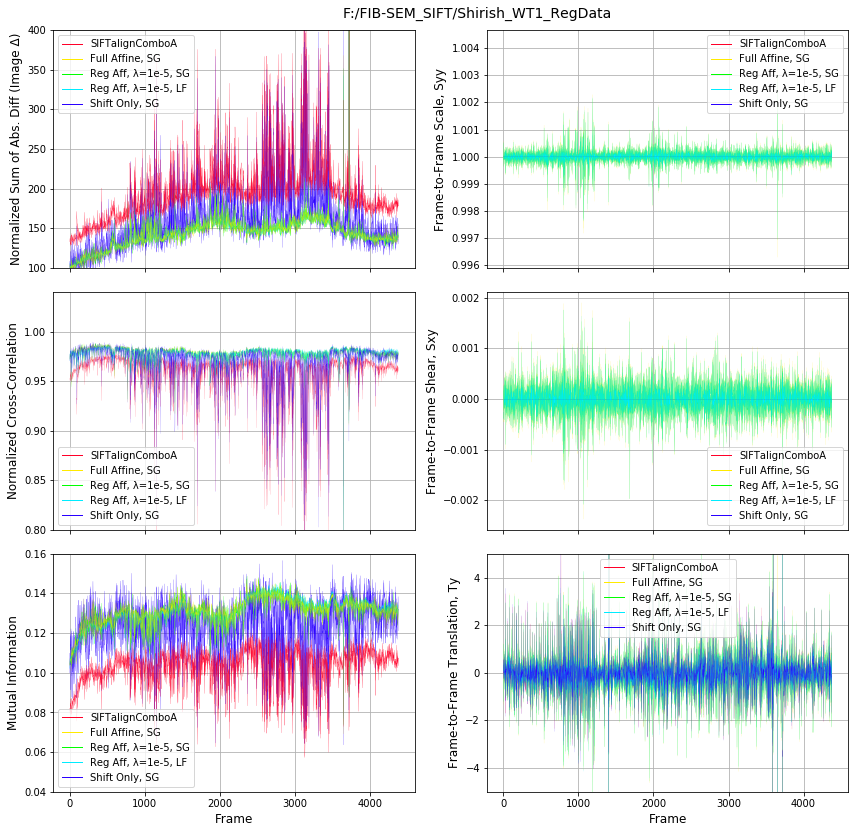

In [297]:
emin = 0.35
emax = 0.55
imdmin=100
imdmax=400
ncc_min=0.8
ncc_max=1.04
mi_min=0.04
mi_max= 0.16
Ty_min= -5
Ty_max= 5

lw=0.1
lw1=1
lw2=0.1
fs=12
fs2=10
fig4, axs4 = subplots(3,2, figsize=(12, 11.5), sharex=True)
fig4.subplots_adjust(left=0.07, bottom=0.04, right=0.99, top=0.96, wspace=0.2, hspace=0.1)
columns=['Image Delta', 'Image NCC', 'Image MI']

ax_imdif = axs4[0,0]
ax_ncc = axs4[1,0]
ax_mi = axs4[2,0]

ax_Syy = axs4[0,1]
ax_Sxy = axs4[1,1]
ax_Ty = axs4[2,1]


ax_imdif.set_ylabel('Normalized Sum of Abs. Diff (Image Δ)', fontsize=fs)
ax_imdif.set_ylim(imdmin, imdmax)
ax_ncc.set_ylabel('Normalized Cross-Correlation', fontsize=fs)
ax_ncc.set_ylim(ncc_min, ncc_max)
ax_mi.set_ylabel('Mutual Information', fontsize=fs)
ax_mi.set_xlabel('Frame', fontsize=fs)
ax_mi.set_ylim(mi_min, mi_max)

ax_Syy.set_ylabel('Frame-to-Frame Scale, Syy', fontsize=fs)
ax_Sxy.set_ylabel('Frame-to-Frame Shear, Sxy', fontsize=fs)
ax_Ty.set_ylabel('Frame-to-Frame Translation, Ty', fontsize=fs)
ax_Ty.set_xlabel('Frame', fontsize=fs)
ax_Ty.set_ylim(Ty_min, Ty_max)

spreads = []
means = []
my_cols = []

for j, reg_data in enumerate(tqdm(reg_datas, desc='generating the registration quality  summary plots')):
    my_col = get_cmap("gist_rainbow_r")((nfls-j)/(nfls))
    my_cols.append(my_col)
    pf = pfs[j]
    #npts = reg_data['Npts']
    #mean_error = reg_data['Mean Abs Error']
    image_diff = reg_data['Image Delta']
    image_ncc = reg_data['Image NCC']
    image_mi = reg_data['Image MI']

    tr_mtr = tran_mtrx_datas[j]
    Syy = tr_mtr['T11 (Syy)']
    Sxy = tr_mtr['T01 (Sxy)']
    Ty = tr_mtr['T12 (Ty)']
    
    metrics = [image_diff, image_ncc, image_mi, Syy, Sxy, Ty]
    spreads.append([get_spread(metr) for metr in metrics])
    means.append([np.mean(metr) for metr in metrics])
    
    #lwv = lw*(abs(j-1)+1)
    lwv = lw

    ax_imdif.plot(image_diff, c=my_col, linewidth=lwv)
    ax_imdif.plot(image_diff[0], c=my_col, linewidth=lw1, label=pf)

    ax_ncc.plot(image_ncc, c=my_col, linewidth=lwv)
    ax_ncc.plot(image_ncc[0], c=my_col, linewidth=lw1, label=pf)

    ax_mi.plot(image_mi, c=my_col, linewidth=lwv)
    ax_mi.plot(image_mi[0], c=my_col, linewidth=lw1, label=pf)

    ax_Syy.plot(Syy, c=my_col, linewidth=lwv)
    ax_Syy.plot(Syy[0], c=my_col, linewidth=lw1, label=pf)

    ax_Sxy.plot(Sxy, c=my_col, linewidth=lwv)
    ax_Sxy.plot(Sxy[0], c=my_col, linewidth=lw1, label=pf)

    ax_Ty.plot(Ty, c=my_col, linewidth=lwv)
    ax_Ty.plot(Ty[0], c=my_col, linewidth=lw1, label=pf)


for j, reg_data in enumerate(tqdm(list(reversed(reg_datas)), desc='modifying quality  summary plots')):

    image_mi = reg_data['Image MI']
    image_diff = reg_data['Image Delta']

    ax_mi.plot(image_mi, c=my_cols[nfls-1-j], linewidth=lw2)
    ax_imdif.plot(image_diff, c=my_cols[nfls-1-j], linewidth=lw2)
    
for ax in axs4.ravel():
    ax.grid(True)
    ax.legend(fontsize=fs2)

ax_imdif.text(0.8, 1.05, data_dir, transform=ax_imdif.transAxes, fontsize=14)
fig4.savefig(os.path.join(data_dir, 'Comparison_of_Registration_Quality_n1.png'), dpi=300)

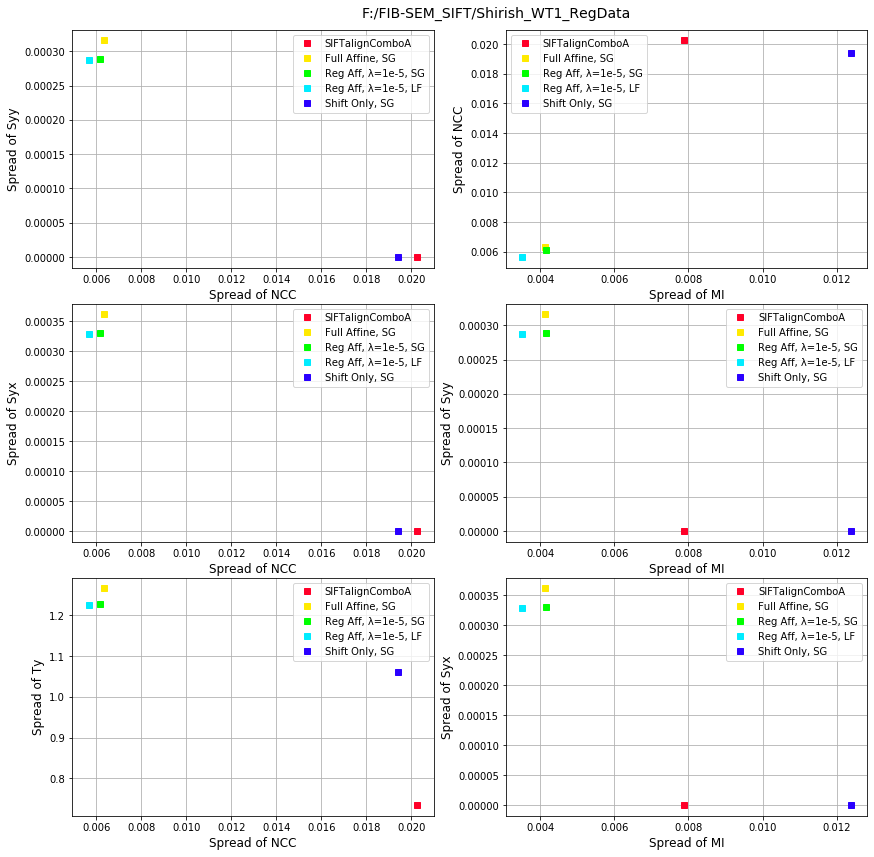

In [298]:
metrics = [image_diff, image_ncc, image_mi, Syy, Sxy, Ty]
fig1, axs1 = subplots(3,2, figsize=(12, 12))
fig1.subplots_adjust(left=0.07, bottom=0.05, right=0.99, top=0.96, wspace=0.2, hspace=0.15)
ax_labels=['Spread of NSAD','Spread of NCC', 'Spread of MI', 'Spread of Syy', 'Spread of Syx', 'Spread of Ty']

combimations = [[1,3], [1,4], [1,5], [2,1], [2,3], [2,4]]
fs=12

for i, ax in enumerate(axs1.flatten(order='F')):

    x, y = combimations[i]
    for j,spread in enumerate(spreads):
        ax.plot(spread[x], spread[y], marker='s', linestyle='', c=my_cols[j], label=pfs[j] )
    ax.grid(True)
    ax.legend()
    ax.set_xlabel(ax_labels[x], fontsize=fs)
    ax.set_ylabel(ax_labels[y], fontsize=fs)

axs1[0,0].text(0.8, 1.05, data_dir, transform=axs1[0,0].transAxes, fontsize=14)
fig1.savefig(os.path.join(data_dir, 'Comparison_of_Registration_Quality_n2.png'), dpi=300)

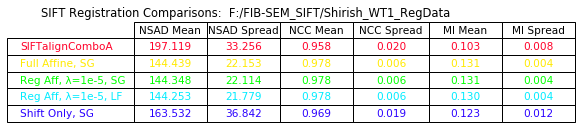

In [300]:
# Generate the Cell Text
cell_text = []
limits = []
rows = pfs
fst=10.5

csv_data = []
for j, (mean, spread) in enumerate(zip(means, spreads)):
    cell_text.append(['{:.3f}'.format(mean[0]), '{:.3f}'.format(spread[0]),
                      '{:.3f}'.format(mean[1]), '{:.3f}'.format(spread[1]),
                      '{:.3f}'.format(mean[2]), '{:.3f}'.format(spread[2])])
    csv_data.append([mean[0], spread[0], mean[1], spread[1], mean[2], spread[2]])

# Generate the table
fig3, ax = subplots(1, 1, figsize=(8,1.6))
fig3.subplots_adjust(left=0.22, bottom=0.01, right=0.99, top=0.88, wspace=0.05, hspace=0.05)
ax.axis(False)
ax.text(-0.20, 1.05, 'SIFT Registration Comparisons:  ' +data_dir, fontsize=fst+1)
llw1=0.3
clw = [llw1, llw1]

columns = ['NSAD Mean', 'NSAD Spread', 'NCC Mean', 'NCC Spread', 'MI Mean', 'MI Spread']

n_cols = len(columns)
n_rows = len(rows)

tbl = ax.table(cellText = cell_text,
               rowLabels = rows,
               colLabels = columns,
               cellLoc = 'center',
               colLoc = 'center',
               bbox = [0.01, 0, 0.995, 1.0],
              fontsize=16)
tbl.auto_set_column_width(col=3)

table_props = tbl.properties()
try:
    table_cells = table_props['child_artists']
except:
    table_cells = table_props['children']

tbl.auto_set_font_size(False)
for j, cell in enumerate(table_cells[0:n_cols*n_rows]):
    cell.get_text().set_color(my_cols[j//n_cols])
    cell.get_text().set_fontsize(fst)
for j, cell in enumerate(table_cells[n_cols*(n_rows+1):]):
    cell.get_text().set_color(my_cols[j])
for cell in table_cells[n_cols*n_rows:]:
#    cell.get_text().set_fontweight('bold')
    cell.get_text().set_fontsize(fst)
    
fig3.savefig(os.path.join(data_dir, 'Comparison_of_Registration_Quality_n3.png'), dpi=300)

index_pfs = [pf.replace('λ', 'l2') for pf in pfs]
registration_summary_fnm = os.path.join(data_dir, 'Comparison_of_Registration_Quality_n3.csv')
reg_summary = pd.DataFrame(np.array(csv_data), columns = columns, index = index_pfs)
reg_summary.to_csv(registration_summary_fnm, index = index_pfs)

In [274]:
dummy = tran_mtrx_datas[0][0:2].copy()

In [292]:
data_dir = 'Z:/FIB-SEM SIFT align code/Shirish_R9_1__RegData'
data_reg_qual_files = ['rawstack-imgA_RegistrationQuality.csv',
                       'SIFTalignCombo-imgA_RegistrationQuality.csv',
                       'Registered_I16_AffineTransform_RANSAC_drmax2_const_scales_shift_subtr_padded_bi-cube_RegistrationQuality.csv',
                       'Registered_I16_AffineTransform_RANSAC_drmax2_const_scls_PF_shift_subtr_padded_bi-lin_RegistrationQuality.csv',
                       'Registered_I16_RegularizedAffineTransform_RANSAC_drmax2.0_const_scls_SG_shift_subtr_padded_l2_1e-05_RegistrationQuality.csv',
                      'Registered_I16_RegularizedAffineTransform_RANSAC_drmax1.0_const_scls_SG_shift_subtr_padded_l2_1e-05_RegistrationQuality.csv']

reg_qual_fls = [os.path.join(data_dir, df) for df in data_reg_qual_files]
tran_mtrx_files = [df.replace('_RegistrationQuality.csv', '_Transform_Matrix_data.csv') for df in reg_qual_fls]
nfls = len(reg_qual_fls)

pfs = ['Raw data',
       'SIFTalignComboA, bi-cube',
        'Full Affine, dr=2, LF, bi-cube',
    'Full Affine, dr=2, PF, bi-lin',
      'Reg Aff, λ=1e-5, dr=2, SG bi-lin',
       'Reg Aff, λ=1e-5, dr=1, SG bi-lin']

reg_datas=[]
tran_mtrx_datas = []
tran_mtrx_res_datas = []

for df in tqdm(reg_qual_fls, desc='reading the registration quality  summary files'):
    try:
        reg_datas.append(pd.read_csv(df))
    except:
        print('file does not exist: ', df)


for df in tqdm(tran_mtrx_files, desc='reading the transformation matrix files'):
    try:
        tr_mx_recalled = pd.read_csv(df)
    except:
        tr_mx_recalled = dummy
    tran_mtrx_datas.append(tr_mx_recalled)
   

reading the registration quality  summary files:   0%|          | 0/6 [00:00<?, ?it/s]

reading the transformation matrix files:   0%|          | 0/6 [00:00<?, ?it/s]

generating the registration quality  summary plots:   0%|          | 0/6 [00:00<?, ?it/s]

modifying quality  summary plots:   0%|          | 0/6 [00:00<?, ?it/s]

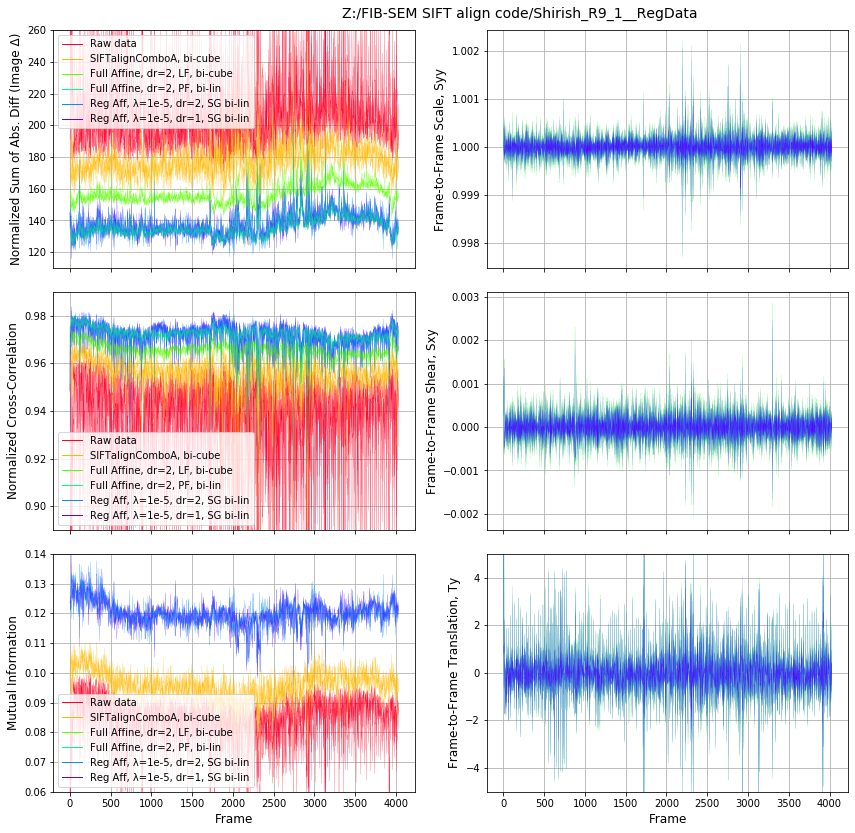

In [293]:
emin = 0.35
emax = 0.55
imdmin=110
imdmax=260
ncc_min=0.89
ncc_max=0.99
mi_min=0.06
mi_max= 0.14
Ty_min= -5
Ty_max= 5

lw=0.1
lw1=1
lw2=0.1
fs=12
fs2=10
fig4, axs4 = subplots(3,2, figsize=(12, 11.5), sharex=True)
fig4.subplots_adjust(left=0.07, bottom=0.04, right=0.99, top=0.96, wspace=0.2, hspace=0.1)
columns=['Image Delta', 'Image NCC', 'Image MI']

ax_imdif = axs4[0,0]
ax_ncc = axs4[1,0]
ax_mi = axs4[2,0]

ax_Syy = axs4[0,1]
ax_Sxy = axs4[1,1]
ax_Ty = axs4[2,1]


ax_imdif.set_ylabel('Normalized Sum of Abs. Diff (Image Δ)', fontsize=fs)
ax_imdif.set_ylim(imdmin, imdmax)
ax_ncc.set_ylabel('Normalized Cross-Correlation', fontsize=fs)
ax_ncc.set_ylim(ncc_min, ncc_max)
ax_mi.set_ylabel('Mutual Information', fontsize=fs)
ax_mi.set_xlabel('Frame', fontsize=fs)
ax_mi.set_ylim(mi_min, mi_max)

ax_Syy.set_ylabel('Frame-to-Frame Scale, Syy', fontsize=fs)
ax_Sxy.set_ylabel('Frame-to-Frame Shear, Sxy', fontsize=fs)
ax_Ty.set_ylabel('Frame-to-Frame Translation, Ty', fontsize=fs)
ax_Ty.set_xlabel('Frame', fontsize=fs)
ax_Ty.set_ylim(Ty_min, Ty_max)

spreads = []
means = []
my_cols = []

for j, reg_data in enumerate(tqdm(reg_datas, desc='generating the registration quality  summary plots')):
    my_col = get_cmap("gist_rainbow_r")((nfls-j)/(nfls))
    my_cols.append(my_col)
    pf = pfs[j]
    #npts = reg_data['Npts']
    #mean_error = reg_data['Mean Abs Error']
    image_diff = reg_data['Image Delta'][1:]
    image_ncc = reg_data['Image NCC'][1:]
    try:
        image_mi = reg_data['Image MI'][1:]
    except:
        image_mi = image_ncc*0

    tr_mtr = tran_mtrx_datas[j]
    Syy = tr_mtr['T11 (Syy)'][1:]
    Sxy = tr_mtr['T01 (Sxy)'][1:]
    Ty = tr_mtr['T12 (Ty)'][1:]
    
    metrics = [image_diff, image_ncc, image_mi, Syy, Sxy, Ty]
    spreads.append([get_spread(metr) for metr in metrics])
    means.append([np.mean(metr) for metr in metrics])
    
    #lwv = lw*(abs(j-1)+1)
    lwv = lw

    ax_imdif.plot(image_diff, c=my_col, linewidth=lwv)
    ax_imdif.plot(image_diff[1], c=my_col, linewidth=lw1, label=pf)

    ax_ncc.plot(image_ncc, c=my_col, linewidth=lwv)
    ax_ncc.plot(image_ncc[1], c=my_col, linewidth=lw1, label=pf)

    ax_mi.plot(image_mi, c=my_col, linewidth=lwv)
    ax_mi.plot(image_mi[1], c=my_col, linewidth=lw1, label=pf)

    ax_Syy.plot(Syy, c=my_col, linewidth=lwv)
    ax_Syy.plot(Syy[1], c=my_col, linewidth=lw1, label=pf)

    ax_Sxy.plot(Sxy, c=my_col, linewidth=lwv)
    ax_Sxy.plot(Sxy[1], c=my_col, linewidth=lw1, label=pf)

    ax_Ty.plot(Ty, c=my_col, linewidth=lwv)
    ax_Ty.plot(Ty[1], c=my_col, linewidth=lw1, label=pf)


for j, reg_data in enumerate(tqdm(list(reversed(reg_datas)), desc='modifying quality  summary plots')):
    image_ncc = reg_data['Image NCC'][1:]
    ax_ncc.plot(image_ncc, c=my_cols[nfls-1-j], linewidth=lw2)
    image_diff = reg_data['Image Delta'][1:]
    ax_imdif.plot(image_diff, c=my_cols[nfls-1-j], linewidth=lw2)
    try:
        image_mi = reg_data['Image MI'][1:]
        ax_mi.plot(image_mi, c=my_cols[nfls-1-j], linewidth=lw2)
    except:
        pass
    
for ax in axs4.ravel():
    ax.grid(True)

for ax in axs4[:, 0]:
    ax.legend(fontsize=fs2)

ax_imdif.text(0.8, 1.05, data_dir, transform=ax_imdif.transAxes, fontsize=14)
fig4.savefig(os.path.join(data_dir, 'Comparison_of_Registration_Quality_n1.png'), dpi=300)

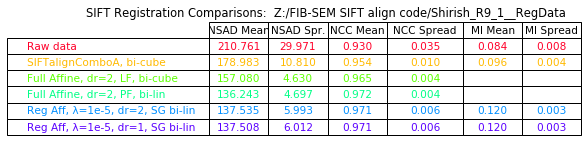

In [295]:
# Generate the Cell Text
cell_text = []
limits = []
rows = pfs
fst=10.5

csv_data = []
for j, (mean, spread) in enumerate(zip(means, spreads)):
    if mean[2] > 0:
        cell_text.append(['{:.3f}'.format(mean[0]), '{:.3f}'.format(spread[0]),
                          '{:.3f}'.format(mean[1]), '{:.3f}'.format(spread[1]),
                          '{:.3f}'.format(mean[2]), '{:.3f}'.format(spread[2])])
    else:
        cell_text.append(['{:.3f}'.format(mean[0]), '{:.3f}'.format(spread[0]),
                          '{:.3f}'.format(mean[1]), '{:.3f}'.format(spread[1]),
                          ' ', ' '])
    csv_data.append([mean[0], spread[0], mean[1], spread[1], mean[2], spread[2]])

# Generate the table
fig3, ax = subplots(1, 1, figsize=(8,1.8))
fig3.subplots_adjust(left=0.35, bottom=0.01, right=0.9995, top=0.88, wspace=0.05, hspace=0.05)
ax.axis(False)
ax.text(-0.32, 1.05, 'SIFT Registration Comparisons:  ' +data_dir, fontsize=fst+1)
llw1=0.3
clw = [llw1, llw1]

columns = ['NSAD Mean', 'NSAD Spr.', 'NCC Mean', 'NCC Spread', 'MI Mean', 'MI Spread']

n_cols = len(columns)
n_rows = len(rows)

tbl = ax.table(cellText = cell_text,
               rowLabels = rows,
               colLabels = columns,
               cellLoc = 'center',
               colLoc = 'center',
               bbox = [0.01, 0, 0.995, 1.0],
              fontsize=16)
tbl.auto_set_column_width(col=3)

table_props = tbl.properties()
try:
    table_cells = table_props['child_artists']
except:
    table_cells = table_props['children']

tbl.auto_set_font_size(False)
for j, cell in enumerate(table_cells[0:n_cols*n_rows]):
    cell.get_text().set_color(my_cols[j//n_cols])
    cell.get_text().set_fontsize(fst)
for j, cell in enumerate(table_cells[n_cols*(n_rows+1):]):
    cell.get_text().set_color(my_cols[j])
for cell in table_cells[n_cols*n_rows:]:
#    cell.get_text().set_fontweight('bold')
    cell.get_text().set_fontsize(fst)
    
fig3.savefig(os.path.join(data_dir, 'Comparison_of_Registration_Quality_n3.png'), dpi=300)

index_pfs = [pf.replace('λ', 'l2') for pf in pfs]
registration_summary_fnm = os.path.join(data_dir, 'Comparison_of_Registration_Quality_n3.csv')
reg_summary = pd.DataFrame(np.array(csv_data), columns = columns, index = index_pfs)
reg_summary.to_csv(registration_summary_fnm, index = index_pfs)